## Adjusting Standard Deviation based on TPM
### Author: Deb Debnath

#### Data loading

In [1]:
import ipywidgets as widgets
from typing import Optional, Sequence

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.classifier import z_score

In [4]:
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)

In [5]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

In [6]:
mean_TPM = 0

In [7]:
num_patients = 243
n_samples = 1000
uncertainties = [10, 25, 50]

In [8]:
seed = 321

In [9]:
np.random.seed(seed)

#### Data preprocessing

In [10]:
pathos = pathos.dropna()
pathos = pathos.loc[pathos.index.dropna(), :]
pathos.index = pathos.index.astype(int).astype(str)

In [11]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

In [12]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

/tmp/ipykernel_230319/2035580270.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [13]:
for col in patients_df.columns:
    if col not in pathos.index:
        print(col)

17906


In [14]:
for col in pathos.index:
    if col not in patients_df.columns:
        pathos = pathos.drop(col)

In [15]:
patients_df = patients_df.loc[:, pathos.index]

#### Conversion to Z-scores and dropping genes below TPM threshold

In [16]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [17]:
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [18]:
z_scores_df = z_scores_df[means >= mean_TPM]
coefficients = coefficients[means >= mean_TPM]
patients_df = patients_df[means >= mean_TPM]

A **differentially classified subject** is a subject (patient) that has one or more simulated scores that produced a different classification into AD/NCI than the actual score.

## Modeling SD based on voom

As from [this](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2014-15-2-r29) paper, the relationship between the standard deviation and the mean can be modeled as

$$
\sqrt{\sigma} = \frac{a}{b + \mu} + c
$$

where $\mu$ and $\sigma$ are mean of the log2(1+TPM) dataset and standard deviation of the TPM dataset, respectively and $a$, $b$, $c$ are constants.

We start with values of $a$ = 0.75, $b$ = 1.0, $c$ = 0.25.

In [19]:
def calculate_scaled_sd(tpm: float, a: float, b: float, c: float, uncertainty_pct: int|float) -> float:
    """
    Calculate scaled standard deviation to simulate based on sqrt sigma = a / (b + mu) + c
    """
    sqrt_sigma = a / (np.log2(tpm+1) + b) + c
    return uncertainty_pct * sqrt_sigma**2.0 / 100.0

In [20]:
def plot_histogram_gene_samples_adaptive_sd(
                            patients_df: pd.DataFrame,
                            uncertainties: list[int], 
                            n_samples: int, 
                            i: int,
                            a_val: float,
                            b_val: float,
                            c_val: float):
    gene = patients_df.index[i]
    row = patients_df.loc[gene, :].sort_values().values
    mean_gene = np.mean(patients_df.iloc[i, :])
    quantiles = np.percentile(row, [1, 25, 50, 75, 99])
    labels = ["lower fence", "25th percentile", "50th percentile", "75th percentile", "upper fence"]
    
    # fig, axs = plt.subplots(nrows=len(uncertainties), ncols=2, sharex=True, sharey=True, figsize=(15, 10))
    fig, axs = plt.subplots(nrows=len(uncertainties), ncols=1, sharex=True, sharey=True, figsize=(15, 10))
    leg_handles, leg_labels = None, None    # Legend handles and labels
    for count, uncertainty in enumerate(uncertainties):
        scaled_sd = calculate_scaled_sd(quantiles, a_val, b_val, c_val, uncertainty)
        samples = np.pow(2.0, np.random.normal(np.log2(quantiles+1), scaled_sd, (n_samples, len(quantiles))))

        # plt.subplot(len(uncertainties), 2, 2*count+1)
        plt.subplot(len(uncertainties), 1, count+1)
        # Plot histograms of sampled data            
        for i in range(samples.shape[1]):
            plt.hist(samples[:, i], bins=30, alpha=0.5, label=labels[i])
        plt.title(f"{uncertainty}% uncertainty, scaled")

        # plt.subplot(len(uncertainties), 2, 2*count+2)
        # for i, quantile in enumerate(quantiles):
            # sample = sample_lognormal_mean_rsd(quantile, uncertainty/100, n_samples)
            # plt.hist(sample, bins=30, alpha=0.5, label=labels[i])
        # plt.title(f"{uncertainty}% uncertainty, unscaled")
        if leg_handles is None and leg_labels is None:
            leg_handles, leg_labels = plt.gca().get_legend_handles_labels()

    # Legend
    fig.legend(leg_handles, leg_labels, loc='upper center', ncol=len(leg_labels), bbox_to_anchor=(0.5, 0.08))
    fig.text(0.5, 0.08, 'Simulated TPM counts', va='center', ha="center") 
    fig.text(0.08, 0.5, 'Counts', va='center', ha="center", rotation="vertical")        
    plt.suptitle(f"Effect of adaptive standard deviation on sampled data for gene {gene}")

[]

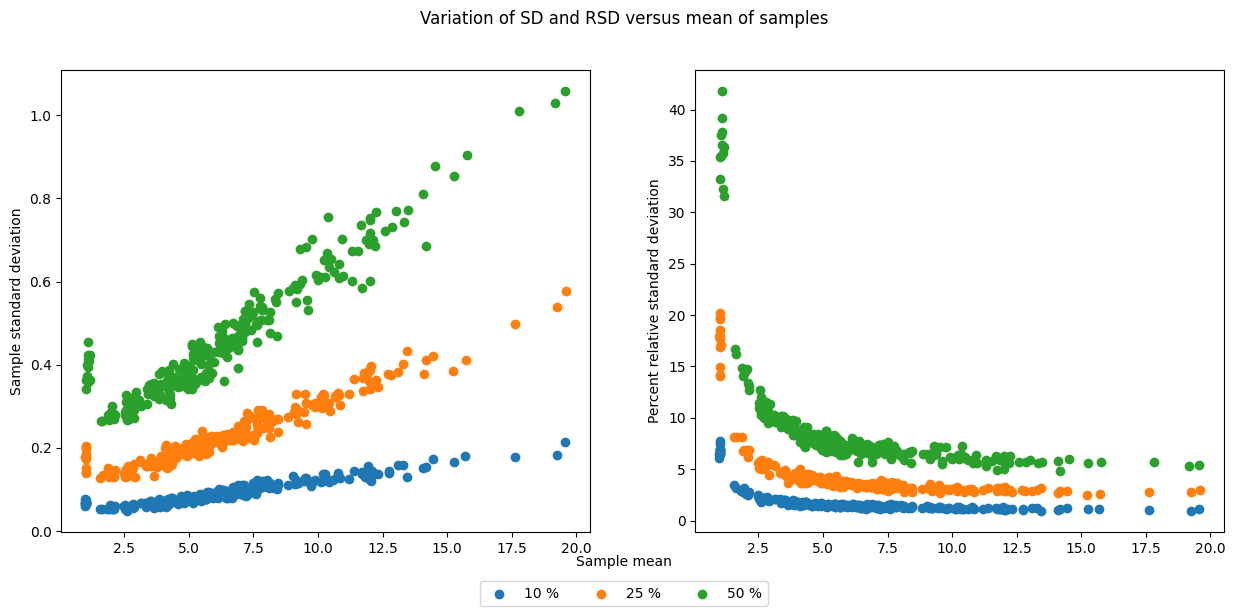

In [21]:
gene_idx = np.random.randint(0, patients_df.shape[0])
row  = patients_df.iloc[gene_idx]
fig = plt.figure(figsize=(15, 6))
for uncert in [10, 25, 50]:
    scaled_sd = calculate_scaled_sd(row, 0.75, 1.0, 0.25, uncert)
    samples = np.pow(2.0, np.random.normal(np.log2(row+1), scaled_sd, (n_samples, len(row))))
    plt.subplot(121)
    plt.scatter(samples.mean(axis=0), samples.std(axis=0), label=f"{uncert} %")
    plt.subplot(122)
    plt.scatter(samples.mean(axis=0), samples.std(axis=0)/samples.mean(axis=0) * 100, label=f"{uncert} %")
plt.subplot(121)
plt.ylabel("Sample standard deviation")
plt.subplot(122)
plt.ylabel("Percent relative standard deviation")

leg_handles, leg_labels = plt.gca().get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper center', ncol=len(leg_labels), bbox_to_anchor=(0.5, 0.04))
fig.suptitle("Variation of SD and RSD versus mean of samples")
fig.text(0.5, 0.06, 'Sample mean', va='center', ha="center") 
plt.plot()

In [22]:
def wrapper_func(gene_idx: int, a: float, b: float, c: float):
    plot_histogram_gene_samples_adaptive_sd(patients_df, [10, 25, 50], n_samples, gene_idx, a, b, c)
gene_idx_slider = widgets.IntSlider(min=0, max=patients_df.shape[0]-1, step=1, value=0, description='Gene index:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
a_slider = widgets.FloatSlider(min=0.0, max=100.0, step=0.01, value=0.75, description='a:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f', layout=widgets.Layout(width='500px'))
b_slider = widgets.FloatSlider(min=0.0, max=100.0, step=0.01, value=1.0, description='b:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f', layout=widgets.Layout(width='500px'))
c_slider = widgets.FloatSlider(min=0.0, max=100.0, step=0.01, value=0.25, description='c:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f', layout=widgets.Layout(width='500px'))
widgets.interactive(wrapper_func, gene_idx=gene_idx_slider, a=a_slider, b=b_slider, c=c_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Gene index:', max=966), FloatSl…

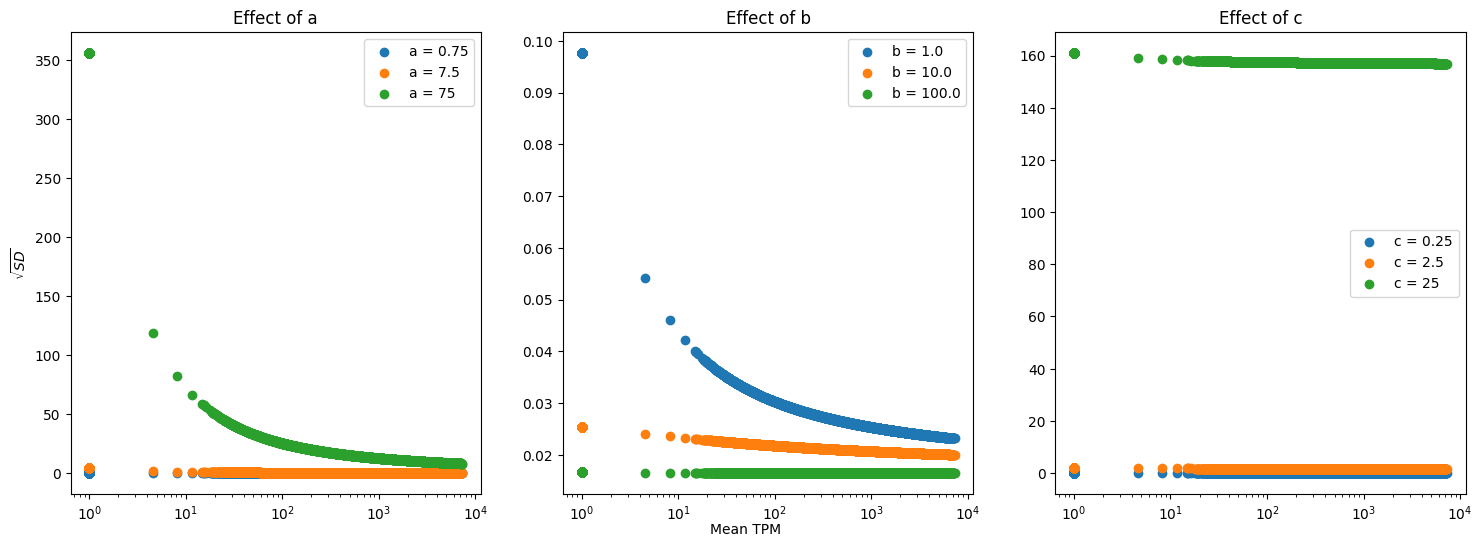

In [24]:
x = np.linspace(1, patients_df.max(), 100)
fig = plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 0.25, 25), label="a = 0.75")
plt.scatter(x, calculate_scaled_sd(x, 7.5, 1.0, 0.25, 25), label="a = 7.5")
plt.scatter(x, calculate_scaled_sd(x, 75, 1.0, 0.25, 25), label="a = 75")
plt.semilogx()
plt.ylabel(r"$\sqrt{SD}$")
plt.legend()
plt.title("Effect of a")
plt.subplot(132)
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 0.25, 25), label="b = 1.0")
plt.scatter(x, calculate_scaled_sd(x, 0.75, 10.0, 0.25, 25), label="b = 10.0")
plt.scatter(x, calculate_scaled_sd(x, 0.75, 100.0, 0.25, 25), label="b = 100.0")
plt.semilogx()
plt.legend()
plt.title("Effect of b")
plt.subplot(133)
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 0.25, 25), label="c = 0.25")
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 2.5, 25), label="c = 2.5")
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 25, 25), label="c = 25")
plt.semilogx()
plt.legend()
plt.title("Effect of c")
fig.text(0.5, 0.05, "Mean TPM", va='center', ha="center")        
plt.show()